# Getting started with the Amazon S3 Connector for PyTorch

The Amazon S3 Connector for PyTorch delivers high throughput for PyTorch training jobs that access or store data in Amazon S3. Using the S3 Connector for PyTorch automatically optimizes performance when downloading training data from and writing checkpoints to Amazon S3, eliminating the need to write your own code to list S3 buckets and manage concurrent requests.

The S3 Connector for PyTorch provides implementations of PyTorch's [dataset primitives](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that you can use to load training data from Amazon S3. It supports both [map-style datasets](https://pytorch.org/docs/stable/data.html#map-style-datasets) for random data access patterns and [iterable-style datasets](https://pytorch.org/docs/stable/data.html#iterable-style-datasets) for streaming sequential data access patterns. The S3 Connector for PyTorch also includes a checkpointing interface to save and load checkpoints directly to Amazon S3, without first saving to local storage.

## Installation

You can install the S3 Connector for PyTorch from PyPI:

In [ ]:
%pip install s3torchconnector

For more detailed installation instructions, see the [README](https://github.com/awslabs/s3-connector-for-pytorch#readme).

We'll also need a few more packages for this example notebook:

In [ ]:
%pip install torch torchdata torchvision Pillow boto3 webdataset

In [3]:
import s3torchconnector

import boto3
import botocore
import io
import itertools
from PIL import Image
import torch.utils.data
import torchdata
import torchvision
import webdataset

## Simple examples

To illustrate how to use the S3 Connector for PyTorch, we've created a public Amazon S3 bucket with some example training data: a subset of cool volcano images from the [GeoNet Aotearoa New Zealand dataset](https://registry.opendata.aws/geonet/).

In [4]:
IMAGES_URI = "s3://bornholt-test-bucket-iad/geonet/images/"
SHARDS_URI = "s3://bornholt-test-bucket-iad/geonet/shards/"
REGION = "us-east-1"

The simplest way to use the S3 Connector for PyTorch is to construct an `S3MapDataset`, a map-style dataset, by specifying an S3 URI (a bucket and optional prefix) and the region the bucket is located in:

In [5]:
dataset = s3torchconnector.S3MapDataset.from_prefix(IMAGES_URI, region=REGION)

You can randomly access a map-style dataset by indexing into it:

In [6]:
object = dataset[42]

list_objects; id=0 bucket="bornholt-test-bucket-iad" continued=false delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=1 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=2 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=3 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=4 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=5 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=6 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=7 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=8 bucket="born

Each element of a dataset in the S3 Connector for PyTorch is a binary stream of the contents of an object in the S3 prefix you specify. To get the actual object contents, call `read` on the object:

In [7]:
content = object.read()
len(content)

get_object; id=15 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0700.00.DISC.01.jpg" range=None if_match=None


271181

The binary stream implements the [`io.IOBase`](https://docs.python.org/3/library/io.html#io.IOBase) interface, so you can pass it to methods that expect a file-like object:

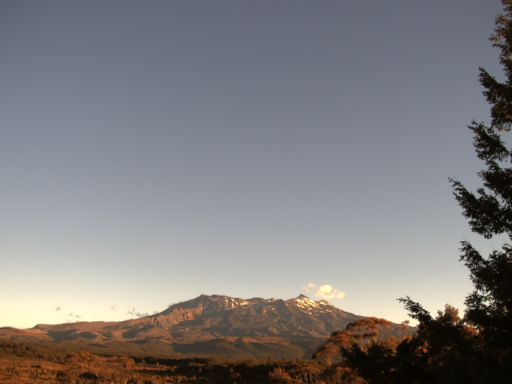

In [8]:
Image.open(object).reduce(4)

Each element of the dataset also exposes metadata about the S3 object, like its S3 key:

In [9]:
object.object_info.key

'geonet/images/DISC/DISC.01/2022.001/2022.001.0700.00.DISC.01.jpg'

Map-style datasets are also iterators, so you can iterate over them to retrieve every object in the S3 prefix that you specify:

'geonet/images/DISC/DISC.01/2022.001/2022.001.0000.00.DISC.01.jpg'

get_object; id=16 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0000.00.DISC.01.jpg" range=None if_match=None


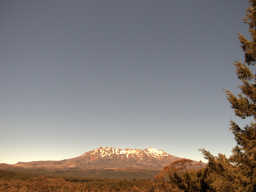

'geonet/images/DISC/DISC.01/2022.001/2022.001.1640.00.DISC.01.jpg'

get_object; id=17 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.1640.00.DISC.01.jpg" range=None if_match=None


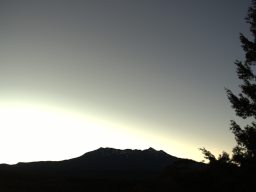

'geonet/images/DISC/DISC.01/2022.002/2022.002.0920.00.DISC.01.jpg'

get_object; id=18 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.002/2022.002.0920.00.DISC.01.jpg" range=None if_match=None


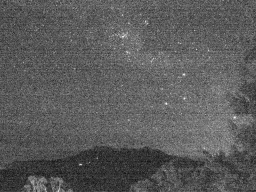

'geonet/images/DISC/DISC.01/2022.003/2022.003.0200.00.DISC.01.jpg'

get_object; id=19 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.003/2022.003.0200.00.DISC.01.jpg" range=None if_match=None


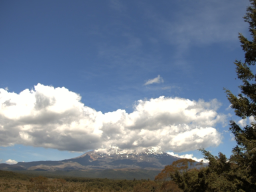

'geonet/images/DISC/DISC.01/2022.003/2022.003.1840.00.DISC.01.jpg'

get_object; id=20 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.003/2022.003.1840.00.DISC.01.jpg" range=None if_match=None


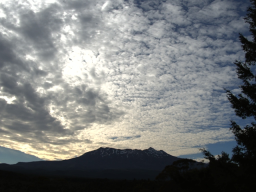

In [10]:
for object in itertools.islice(dataset, 0, 500, 100):
    display(object.object_info.key)
    display(Image.open(object).reduce(8))

## Working with `DataLoader`s

While you can work directly with datasets, most PyTorch training loops will instead use a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), a wrapper around a dataset that supports customizable ordering, automatic batching, and multi-process data loading.

`DataLoader` batches should usually contain tensors or NumPy arrays, but our dataset so far has contained S3 objects. To convert these into tensors for use in training, we can use the optional `transform` argument to `S3MapDataset` or `S3IterableDataset` to apply a function to each object in the dataset:

In [11]:
def load_image(object):
    img = Image.open(object)
    return (object.key, torchvision.transforms.functional.pil_to_tensor(img))

dataset = s3torchconnector.S3MapDataset.from_prefix(IMAGES_URI, region=REGION, transform=load_image)

In [12]:
key, img = dataset[0]
img.shape

list_objects; id=0 bucket="bornholt-test-bucket-iad" continued=false delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=1 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=2 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=3 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=4 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=5 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=6 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=7 bucket="bornholt-test-bucket-iad" continued=true delimiter="" max_keys="1000" prefix="geonet/images/"
list_objects; id=8 bucket="born

torch.Size([3, 1536, 2048])

You can construct a `DataLoader` as a wrapper around an `S3MapDataset` or `S3IterableDataset`, passing in arguments such as the batch size you want to use:

In [13]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4)

A `DataLoader` is an iterator over *batches* of data samples (in this case, images):

In [14]:
for keys, images in itertools.islice(loader, 3):
    print(keys)
    print(images.shape)

get_object; id=16 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0010.00.DISC.01.jpg" range=None if_match=None
get_object; id=17 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0020.00.DISC.01.jpg" range=None if_match=None
get_object; id=18 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0030.00.DISC.01.jpg" range=None if_match=None
get_object; id=19 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0040.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.001/2022.001.0000.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0010.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0020.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0030.00.DISC.01.jpg')
torch.Size([4, 3, 1536, 2048])


get_object; id=20 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0050.00.DISC.01.jpg" range=None if_match=None
get_object; id=21 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0100.00.DISC.01.jpg" range=None if_match=None
get_object; id=22 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0110.00.DISC.01.jpg" range=None if_match=None
get_object; id=23 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0120.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.001/2022.001.0040.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0050.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0100.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0110.00.DISC.01.jpg')
torch.Size([4, 3, 1536, 2048])


get_object; id=24 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0130.00.DISC.01.jpg" range=None if_match=None
get_object; id=25 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0140.00.DISC.01.jpg" range=None if_match=None
get_object; id=26 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.001/2022.001.0150.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.001/2022.001.0120.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0130.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0140.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.001/2022.001.0150.00.DISC.01.jpg')
torch.Size([4, 3, 1536, 2048])


You can also use a `DataLoader` to automatically shuffle your training set, which can help improve training quality and convergence. Notice how the keys are no longer ordered:

In [15]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
for keys, images in itertools.islice(loader, 3):
    print(keys)

get_object; id=27 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.064/2022.064.1550.00.DISC.01.jpg" range=None if_match=None
get_object; id=28 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.089/2022.089.0230.00.DISC.01.jpg" range=None if_match=None
get_object; id=29 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.007/2022.007.1110.00.DISC.01.jpg" range=None if_match=None
get_object; id=30 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.023/2022.023.0410.00.DISC.01.jpg" range=None if_match=None
get_object; id=31 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.021/2022.021.1250.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.064/2022.064.1550.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.089/2022.089.0230.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.007/2022.007.1110.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.023/2022.023.0410.00.DISC.01.jpg')


get_object; id=32 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.095/2022.095.2210.00.DISC.01.jpg" range=None if_match=None
get_object; id=33 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.059/2022.059.2030.00.DISC.01.jpg" range=None if_match=None
get_object; id=34 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.042/2022.042.1240.00.DISC.01.jpg" range=None if_match=None
get_object; id=35 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.010/2022.010.2300.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.021/2022.021.1250.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.095/2022.095.2210.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.059/2022.059.2030.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.042/2022.042.1240.00.DISC.01.jpg')


get_object; id=36 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.092/2022.092.1440.00.DISC.01.jpg" range=None if_match=None
get_object; id=37 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.072/2022.072.1310.00.DISC.01.jpg" range=None if_match=None
get_object; id=38 bucket="bornholt-test-bucket-iad" key="geonet/images/DISC/DISC.01/2022.008/2022.008.0410.00.DISC.01.jpg" range=None if_match=None


('geonet/images/DISC/DISC.01/2022.010/2022.010.2300.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.092/2022.092.1440.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.072/2022.072.1310.00.DISC.01.jpg', 'geonet/images/DISC/DISC.01/2022.008/2022.008.0410.00.DISC.01.jpg')


### Multi-process data loading

To speed up data loading, you can configure a PyTorch `DataLoader` to automatically spawn a number of worker processes and load data in parallel in each process, using the `num_workers` argument:

In [16]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=4)

Parallel data loading is especially important when loading training data from cloud storage services like Amazon S3, where the time to load each individual training sample may be high, but loading of many samples can happen in parallel. Multiple workers will give the best training throughput. We generally recommend setting `num_workers` to the number of vCPUs on your instance.

**Important**: When combining multi-process data loading with `S3IterableDataset`, by default each worker process will get its own replica of the dataset, and so each training sample will be duplicated `num_workers` times by the `DataLoader`. This is very likely not the behavior you want. We're currently [tracking this issue on GitHub](https://github.com/awslabs/s3-connector-for-pytorch/issues/53). In the meantime, as a workaround, you can use `torchdata` to wrap an `S3IterableDataset` and then shard it across workers:

In [17]:
dataset = s3torchconnector.S3IterableDataset.from_prefix(IMAGES_URI, region=REGION, transform=load_image)
dataset = torchdata.datapipes.iter.IterableWrapper(dataset)
dataset = dataset.sharding_filter()

loader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=4)

## Training data formats for Amazon S3

When storing training data in your Amazon S3 bucket, collecting training samples into preprocessed *shards* can improve the throughput of your training jobs as well as reducing the cost of loading the data. A shard is a single Amazon S3 object that contains many samples, rather than storing each individual training sample as a separate object. Collecting samples into larger shards allow your training jobs to make the best use of S3's elastic throughput by streaming the shards in their entirety, hiding the latency of individual requests. and lowering request costs.

There are several ways to collect training data into shards. For textual data used to pre-train or fine-tune large language models, even simple sharding techniques like text files with one sample per line can be an effective sharding technique. For larger datasets or other data formats, consider open-source sharding formats like [WebDataset](https://github.com/webdataset/webdataset) or TensorFlow’s [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord).

For example, you can use `S3IterableDataset` to stream training data stored in S3 in WebDataset format:


list_objects; id=0 bucket="bornholt-test-bucket-iad" continued=false delimiter="" max_keys="1000" prefix="geonet/shards/"
get_object; id=1 bucket="bornholt-test-bucket-iad" key="geonet/shards/geonet-shard-0000.tar" range=None if_match=None


'2022.073.1810.00.DISC.01.jpg.image.jpg'

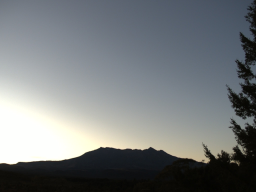

'2022.073.0010.00.DISC.01.jpg.image.jpg'

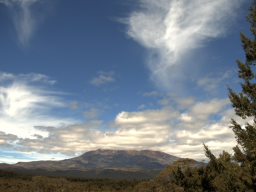

'2022.073.1610.00.DISC.01.jpg.image.jpg'

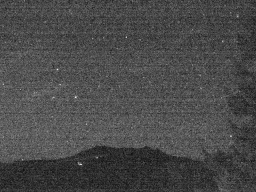

'2022.073.1830.00.DISC.01.jpg.image.jpg'

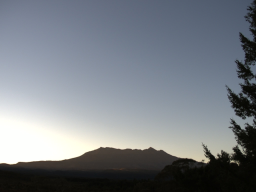

'2022.073.1240.00.DISC.01.jpg.image.jpg'

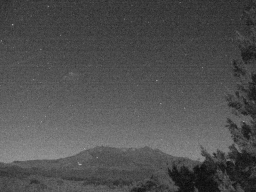

In [18]:
def shard_to_dict(object):
    return {"url": object.object_info.key, "stream": object}

dataset = s3torchconnector.S3IterableDataset.from_prefix(SHARDS_URI, region=REGION, transform=shard_to_dict)
dataset = webdataset.tariterators.tar_file_expander(dataset)

for sample in itertools.islice(dataset, 5):
    display(sample["fname"])
    display(Image.open(io.BytesIO(sample["data"])).reduce(8))

Preprocessing your training samples into shards is also a good opportunity to optimize your training data format to reduce cost and improve training throughput. For example, you can pre-apply transformations like resizing, normalization, and tensor conversion to image or video datasets to avoid the overhead of these transformations during training. You can also compress the sharded objects before uploading them to Amazon S3 to reduce storage costs. Finally, sharded objects are more likely to be larger than the 128 KiB minimum size to be eligible for [S3 Intelligent-Tiering](https://aws.amazon.com/s3/storage-classes/intelligent-tiering/), which can further reduce storage costs for infrequently accessed training data.

## Model checkpointing

**[talk about checkpointing, torch.save]**

## An end-to-end example

**[train an actual model, using dataset for training data and checkpointing for saves. grab a simple example from HuggingFace or something.]**